# LangSmith Deployments (LSD) Demo

Welcome! This notebook demonstrates how to interact with a deployed LangGraph agent using LangSmith Deployments.

## Step 1: Get Your Agent's API URL

First, navigate to the **LangSmith UI** and locate your deployed agent. Copy the **API URL** from the deployment page:

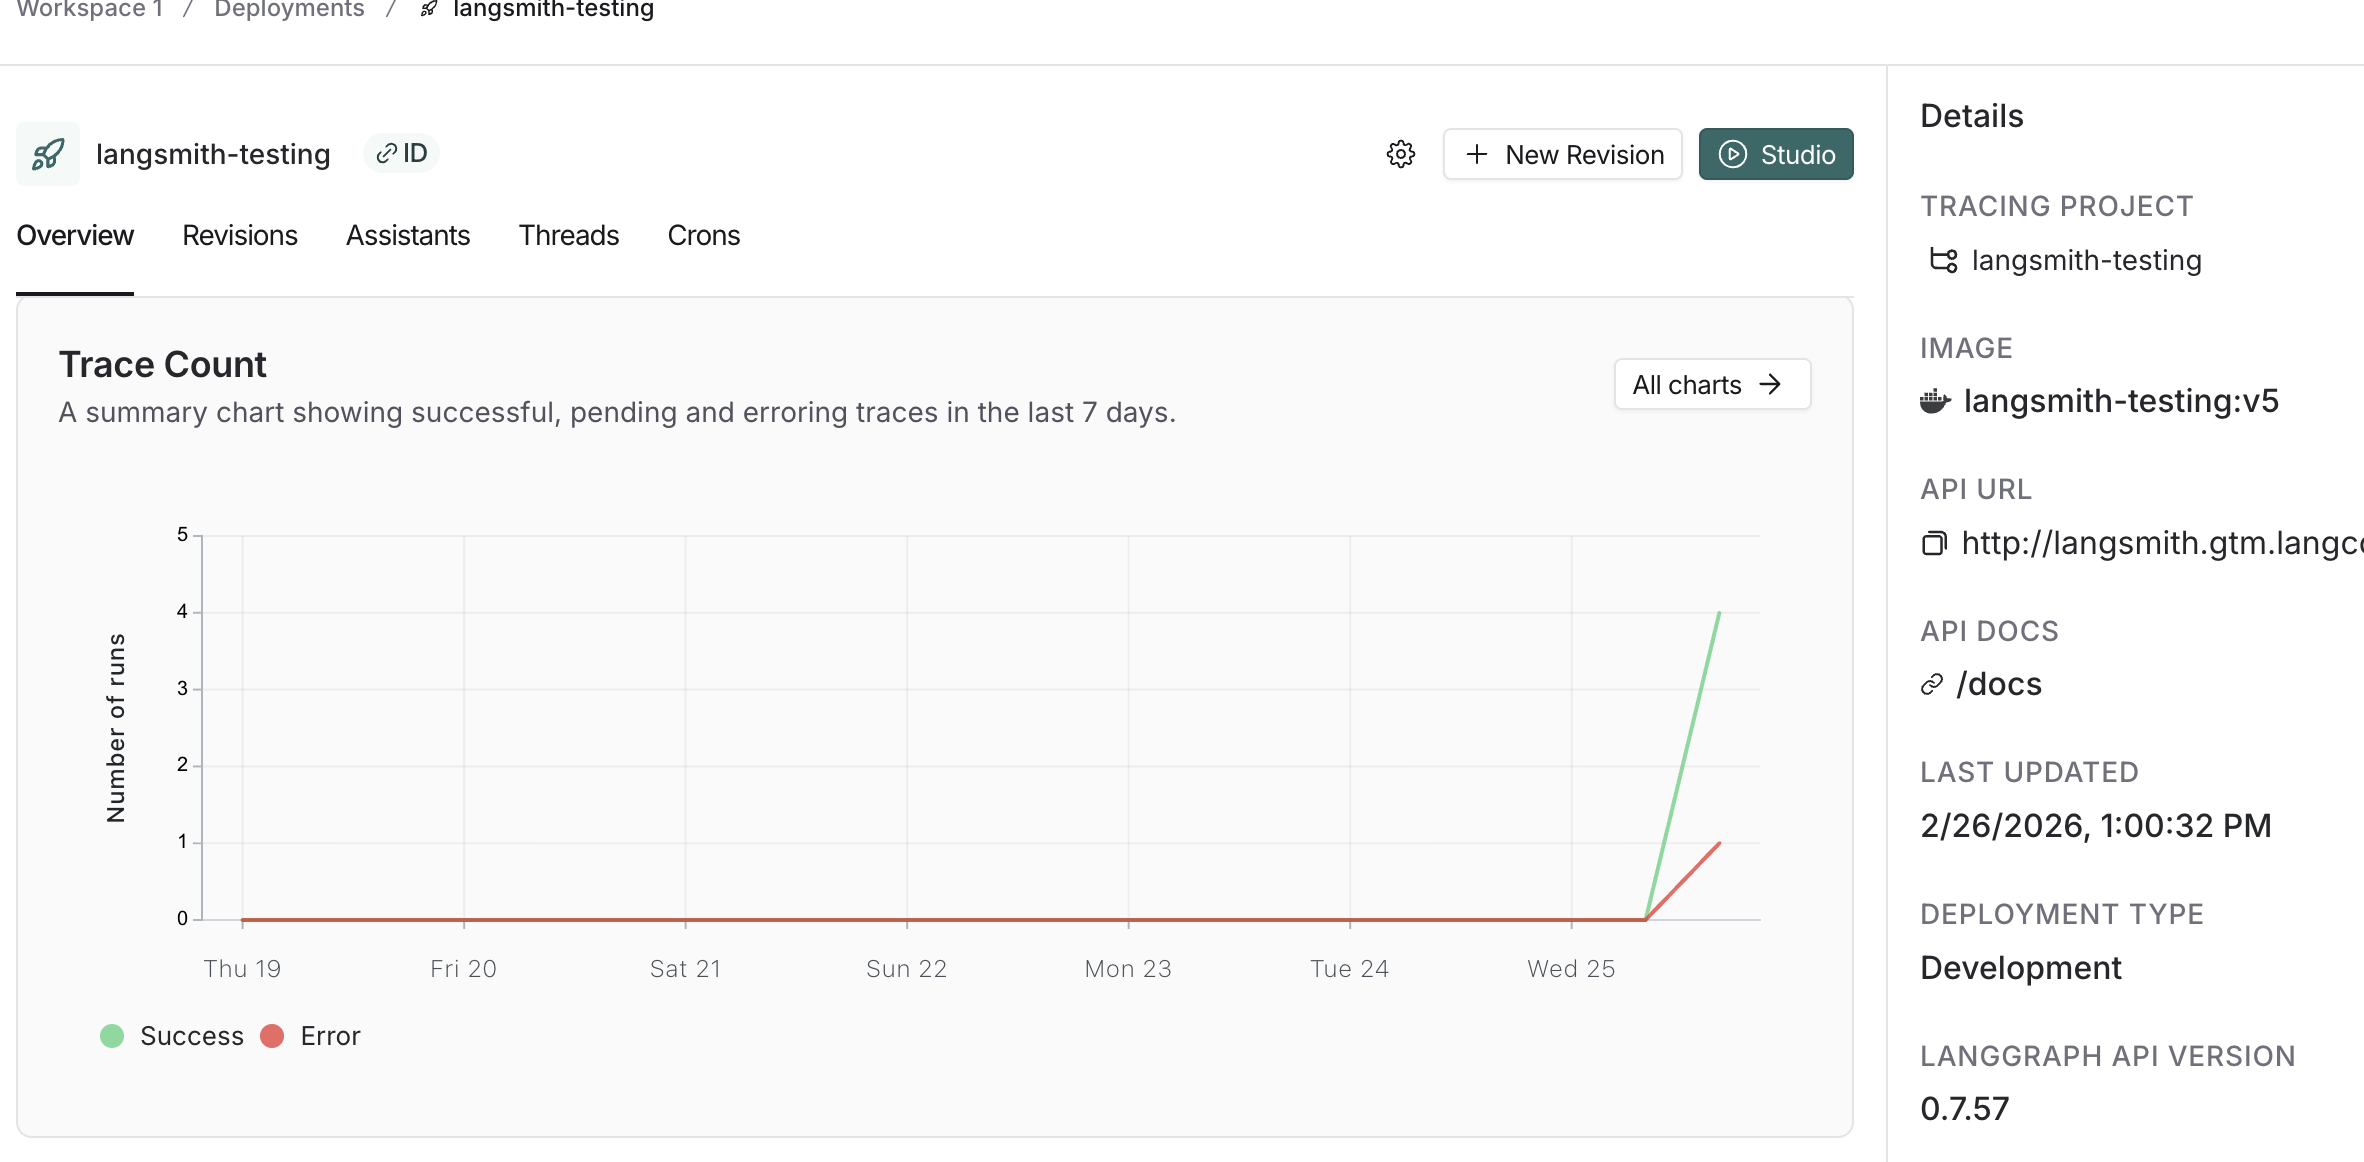

## Step 2: Explore the API Documentation

Before we start coding, take some time to explore the **API DOCS** page:

1. Find the API DOCS link just under the API URL in the LangSmith UI
2. Review the available APIs for:
   - **Assistants** - Manage your agent configurations
   - **Threads** - Create and manage conversation threads
   - **Runs** - Execute agent runs
   - **Crons** - Schedule recurring tasks
   - **A2A (Agent-to-Agent)** - Enable agent communication
   - **MCP (Model Context Protocol)** - Advanced context management

Once you're familiar with the API structure, let's start interacting with the agent using the `langgraph-sdk`!

In [ ]:
import asyncio

# from dotenv import load_dotenv
from langgraph_sdk import get_client

# load_dotenv(override=True)
url="http://langsmith.gtm.langconnect.langchain.com/lgp/langsmith-testing-48457473df775f9da6c60c058ab3f06c"
api_key="YOUR_LANGSMITH_API_KEY"
# Assistant ID we want to use

# Create client with auth header and assistant ID
client = get_client(url=url, api_key=api_key)
ASSISTANT_ID = "simple_text2sql"


## Method 1: Using ThreadsClient and RunsClient

In this example, we'll use the low-level SDK clients to create threads and execute runs.

**Key Components:**
- **ThreadsClient** - Manages conversation threads ([docs](https://reference.langchain.com/python/langgraph-sdk/_async/threads/ThreadsClient))
- **RunsClient** - Handles agent execution ([docs](https://reference.langchain.com/python/langgraph-sdk/_async/runs/RunsClient))

### Example 1a: Creating a Thread and Waiting for Results

This approach creates a persistent thread and waits for the complete response:

In [ ]:
# create a thread
thread = await client.threads.create()
thread_id = thread["thread_id"]
input = {"messages": [{"role": "user", "content": "How many songs do you have by Queen?"}]}
print(f"\nTesting with assistant {ASSISTANT_ID} in thread {thread_id}")
# Run the graph until the interrupt is hit.
result = await client.runs.wait(
    thread_id,
    ASSISTANT_ID,
    input=input   # (1)!
)
print(f"answer: {result['messages'][-1]['content']}")

### Viewing Traces in LangSmith

After running your agent, you can view detailed execution traces in LangSmith:

1. Navigate to **Recent Traces** in the LangSmith UI
2. Click on your trace to see the complete execution flow
3. Inspect each step, including inputs, outputs, and timing

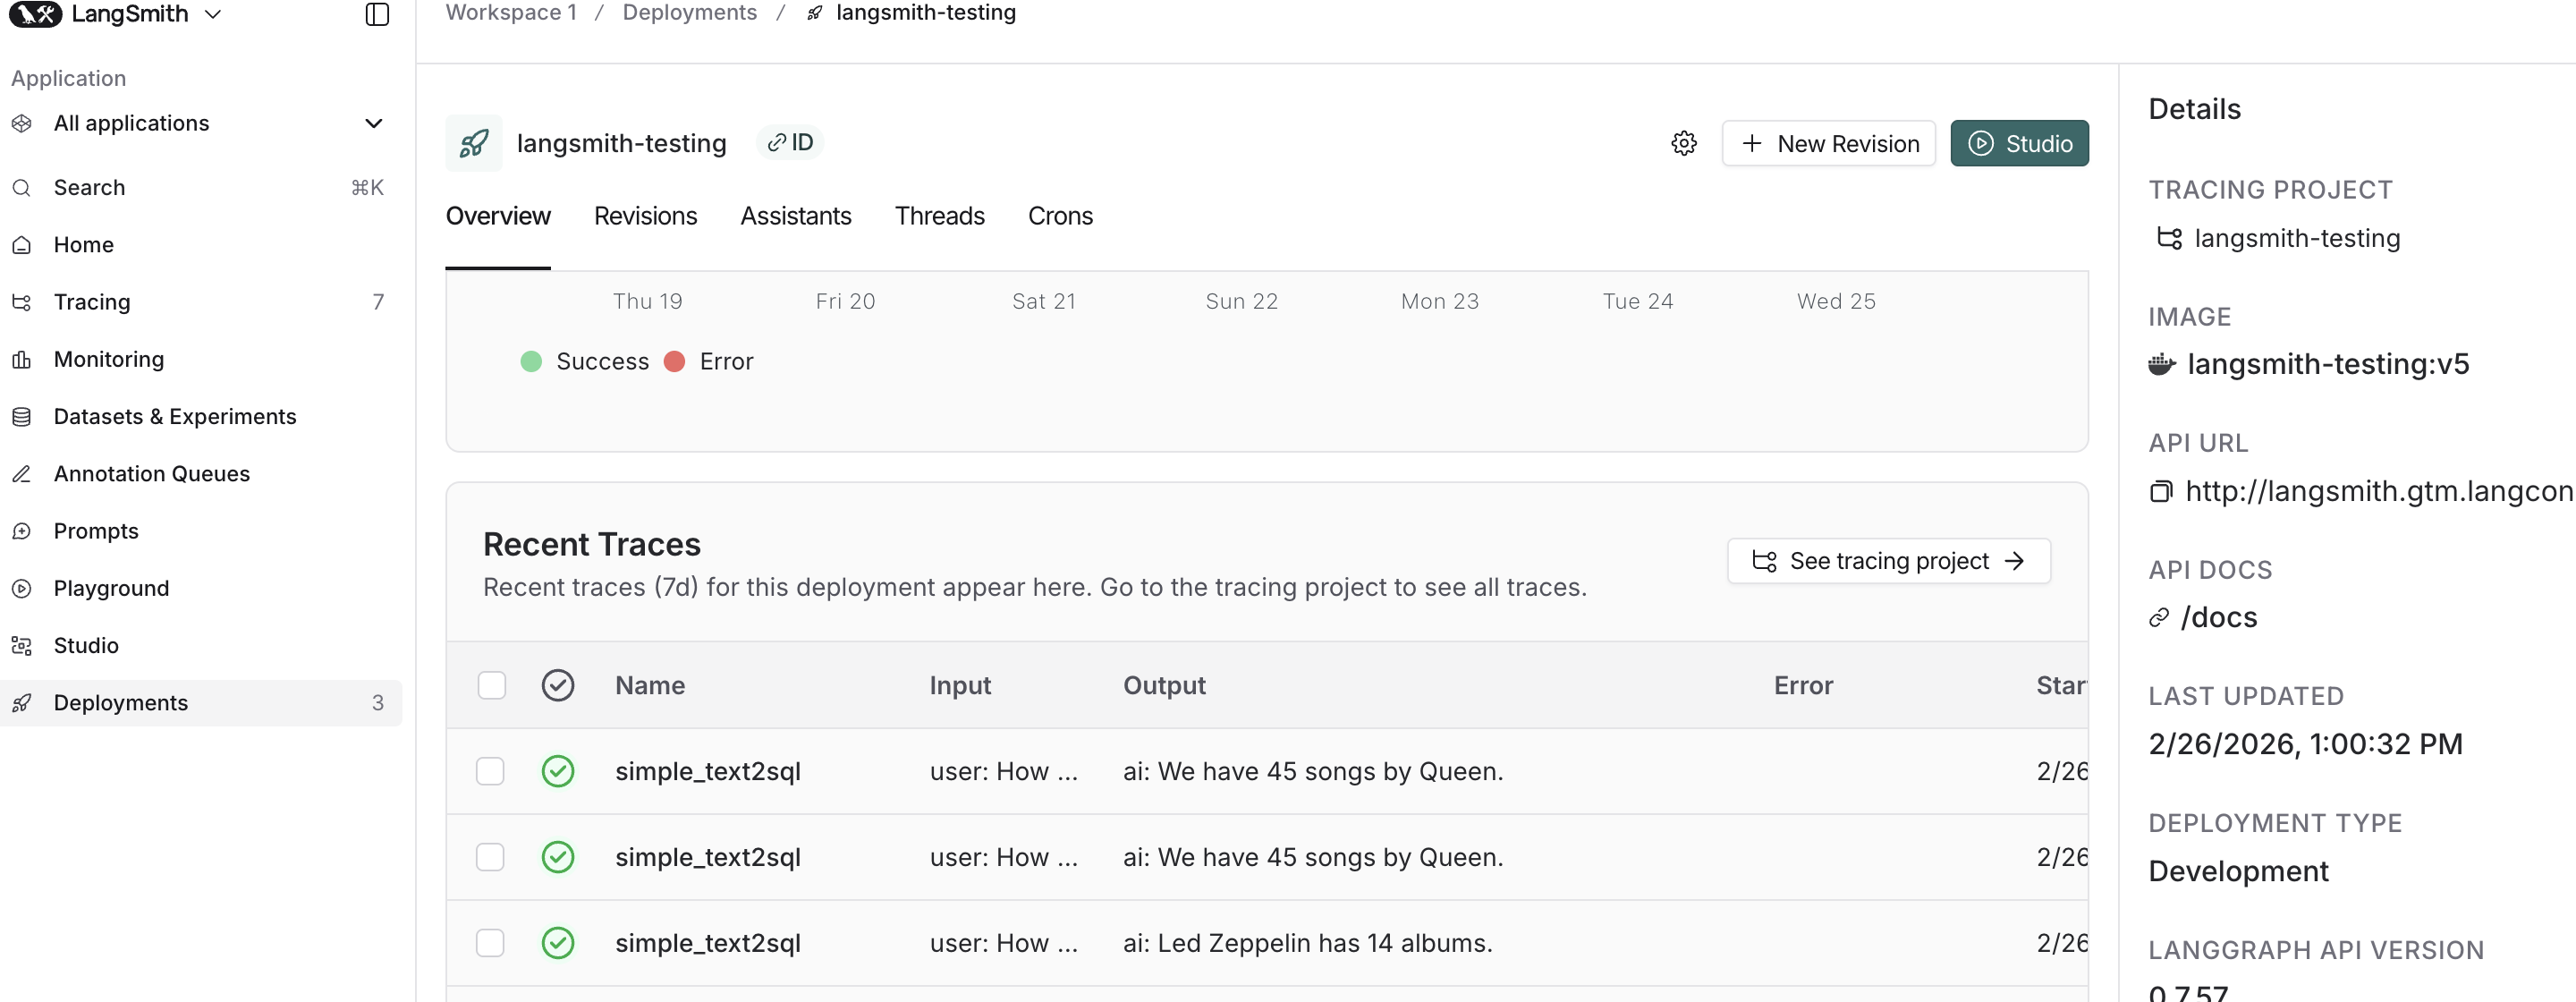

### Example 1b: Streaming Results (Threadless Run)

For real-time responses, you can stream the agent's execution without creating a persistent thread:

In [ ]:
input = {"messages": [{"role": "user", "content": "How many albums does Led Zeppelin have?"}]}

async for chunk in client.runs.stream(
    None,  # Threadless run
    ASSISTANT_ID,  # This will go in the body automatically
    input=input,
    stream_mode="updates",
):
    print(f"Received event: {chunk.event}")
    print(f"Data: {chunk.data}\n")

## Method 2: Using RemoteGraph (High-Level API)

The `RemoteGraph` class provides a simpler, more intuitive way to interact with deployed agents. It wraps the low-level SDK and offers a familiar interface similar to LangGraph's local development.

**Benefits:**
- Simpler API - no need to manage threads and runs separately
- Familiar interface - works like a local LangGraph
- Built-in distributed tracing - automatic trace correlation

In [ ]:
from langgraph.pregel.remote import RemoteGraph

# Create a RemoteGraph instance pointing to the deployed agent
simple_text2sql_agent = RemoteGraph(
    ASSISTANT_ID, 
    url=url, 
    api_key=api_key,
    distributed_tracing=True  # Enable distributed tracing for better observability
)

### Using RemoteGraph to Invoke the Agent

With `RemoteGraph`, you can invoke your agent with a simple, clean API:

#### Example: Simple Invoke

In [ ]:
from langchain_core.messages import HumanMessage

# Query the agent
query = "How many songs are there by The Beatles?"

result = await simple_text2sql_agent.ainvoke({
    "messages": [HumanMessage(content=query)]
})

# Display the final response
print(f"Question: {query}")
print(f"Answer: {result['messages'][-1].content}")

# Add a separator for the next section
print("\n" + "="*80 + "\n")

## Method 3: Using the REST API Directly

For maximum flexibility and language-agnostic access, you can interact with your deployed agent using direct HTTP requests to the LangGraph REST API.

**When to use this approach:**
- Working in a language without SDK support
- Need full control over HTTP requests
- Integrating with non-Python systems
- Building custom clients or wrappers

**Key Endpoints:**
- `POST /runs/wait` - Stateless run, wait for complete result
- `POST /runs/stream` - Stateless run with streaming
- `POST /threads/{thread_id}/runs/wait` - Run on thread, wait for result
- `POST /threads/{thread_id}/runs/stream` - Run on thread with streaming

**Required Headers:**
- `Content-Type: application/json`
- `X-Api-Key: <your-api-key>`
- `X-Auth-Scheme: langsmith-api-key`

### Example 3a: Stateless Run (Wait for Result)

In [ ]:
import requests
import json

# Configure the API request
headers = {
    "Content-Type": "application/json",
    "X-Api-Key": api_key,
    "X-Auth-Scheme": "langsmith-api-key"
}

# Prepare the request payload
payload = {
    "assistant_id": ASSISTANT_ID,
    "input": {
        "messages": [
            {
                "role": "user",
                "content": "How many albums does Pink Floyd have?"
            }
        ]
    }
}

# Make the API request
response = requests.post(
    f"{url}/runs/wait",
    headers=headers,
    json=payload
)

# Parse and display the response
if response.status_code == 200:
    result = response.json()
    final_message = result['messages'][-1]
    print(f"Question: {payload['input']['messages'][0]['content']}")
    print(f"Answer: {final_message['content']}")
else:
    print(f"Error: {response.status_code}")
    print(response.text)

## Summary

In this notebook, you learned **three ways** to interact with LangSmith Deployments:

### Method 1: ThreadsClient + RunsClient (Low-Level SDK)
- **Best for:** Fine-grained control over threads and runs
- **Pros:** Full control, persistent threads, detailed run management
- **Cons:** More verbose, requires managing threads/runs separately
- **Use case:** Complex workflows, conversation history, stateful interactions

### Method 2: RemoteGraph (High-Level SDK)
- **Best for:** Quick integration and familiar LangGraph interface
- **Pros:** Simple API, automatic thread management, seamless tracing
- **Cons:** Less control over low-level details
- **Use case:** Drop-in replacement for local LangGraph, rapid prototyping

### Method 3: REST API (Direct HTTP)
- **Best for:** Language-agnostic integration and custom clients
- **Pros:** Works from any language, maximum flexibility, no SDK required
- **Cons:** More boilerplate, manual error handling
- **Use case:** Non-Python environments, custom integrations, microservices

### Next Steps

- **Experiment** with different queries and observe traces in LangSmith
- **Try streaming** responses with `RemoteGraph` using `.astream()`
- **Explore error handling** and retry logic for production use
- **Set up cron jobs** for scheduled agent runs via the API
- **Read the docs** at the `/docs` endpoint for your deployment

Happy building! 🚀